## TTC Data Linear Regression 
Goal: Given weather and TTC data, predict the delay time (min) given snow preicipitation on ground (mm)

### Data Import and Clean

In [68]:
#downloading files from Toronto Open Data
import requests 
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
## Create a file paths for all files
file_paths = ["ttc-subway-delay-jan-2014-april-2017.xlsx",
              "ttc-subway-delay-may-december-2017.xlsx",  
              "ttc-subway-delay-data-2018.xlsx",
              "ttc-subway-delay-data-2019.xlsx",
              "ttc-subway-delay-data-2020.xlsx",
              "ttc-subway-delay-data-2021.xlsx",
              "ttc-subway-delay-data-2022.xlsx",
              "ttc-subway-delay-data-2023.xlsx"]

# Read each file into a DataFrame and store them in a list
dataframes = [pd.read_excel(fp) for fp in file_paths]

# Concatenate all the DataFrames into one
TTC_delay_raw = pd.concat(dataframes, ignore_index=True)

TTC_delay_raw.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


## Cleaning for TTC 2023 delay data

Add two new columns to the TTC 2023 delay data, one is time intervel (i.e. 9:00 to 10:00), one is period (i.e. morning rush hour)

In [70]:
# Convert 'HH:MM' format to timedelta and Add seconds to match 'HH:MM:SS' format
TTC_delay_raw['Time'] = TTC_delay_raw['Time'] + ":00"

# Add the 'time' timedelta to the DatetimeIndex
TTC_delay_raw.index = TTC_delay_raw["Date"] + pd.to_timedelta(TTC_delay_raw['Time'])

TTC_delay_raw = TTC_delay_raw.drop(columns='Time')
TTC_delay_raw = TTC_delay_raw.drop(columns='Date')
TTC_delay_raw.index.name = "Date/Time"

TTC_delay_raw.head()


,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
Date/Time,,,,,,,,
2014-01-01 00:21:00,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
2014-01-01 02:06:00,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2014-01-01 02:40:00,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
2014-01-01 03:10:00,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
2014-01-01 03:20:00,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


Create a new column to see the Date/Time falls on what time interval (time interval is for one hour)

In [71]:
## Create a function to capture the what time interval does each datetime index falls

def round_to_nearest_hour(timestamp):
    # Convert the timestamp to a pandas datetime object
    dt = pd.to_datetime(timestamp)
    rounded_dt = dt.round('H')

    # Format the result as a string
    result = rounded_dt.strftime('%Y-%m-%d %H:%M:%S')

    return result

In [72]:
## Create a new column for time interval

TTC_delay_raw['nearest_hour'] = TTC_delay_raw.index.map(round_to_nearest_hour)
TTC_delay_raw.head()


,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,nearest_hour
Date/Time,,,,,,,,,
2014-01-01 00:21:00,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,2014-01-01 00:00:00
2014-01-01 02:06:00,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,2014-01-01 02:00:00
2014-01-01 02:40:00,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,2014-01-01 03:00:00
2014-01-01 03:10:00,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,2014-01-01 03:00:00
2014-01-01 03:20:00,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,2014-01-01 03:00:00


Replace 0 value with NaN for columns "Min delay" and "Min Gap"


In [73]:
## Replace 0 value with NaN for columns "Min delay" and "Min Gap"
TTC_delay_raw ["Min Delay"] = TTC_delay_raw ["Min Delay"].replace(0, np.nan)
TTC_delay_raw ["Min Gap"] = TTC_delay_raw ["Min Gap"].replace(0, np.nan)

## Drop the rows where both min delay and min gap is 0 (NaN)
TTC_delay_raw_drop00 = TTC_delay_raw.dropna(subset=["Min Delay","Min Gap"], how='all')

## TTC Delay code - Import data and some cleaning

In [74]:
## Import the TTC delay code name dataset

TTC_delay_code_name_raw = pd.read_excel("ttc-subway-delay-codes.xlsx", index_col=0)
TTC_delay_code_name_raw.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
NaN,NaN,SUB RMENU CODE,CODE DESCRIPTION,NaN,NaN,SRT RMENU CODE,CODE DESCRIPTION
NaN,1.0,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
NaN,2.0,EUAL,Alternating Current,NaN,2.0,ERBO,Body
NaN,3.0,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
NaN,4.0,EUBK,Brakes,NaN,4.0,ERCO,Couplers


### Reorganize ttc-delay-code dataset 

In [75]:
## Remove the first row
TTC_delay_code_name_raw = TTC_delay_code_name_raw.iloc[1:]

## Since the code abbreviation and code describtion are divided into four different columns, get them into two dataframe first and concat into one
TTC_delay_code_name_raw_1 = pd.DataFrame({
    "Code": TTC_delay_code_name_raw.iloc[:,1],
    "Code discription": TTC_delay_code_name_raw.iloc[:,2]
})
TTC_delay_code_name_raw_2 = pd.DataFrame({
    "Code": TTC_delay_code_name_raw.iloc[:,5],
    "Code discription": TTC_delay_code_name_raw.iloc[:,6]
})

TTC_delay_code_name = pd.concat([TTC_delay_code_name_raw_1, TTC_delay_code_name_raw_2], axis=0)

## Reset the index
TTC_delay_code_name = TTC_delay_code_name.reset_index(drop=True)

## Take a look
TTC_delay_code_name.head()

,Code,Code discription
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [76]:
TTC_delay_code_name['Code discription'] = TTC_delay_code_name['Code discription'].fillna("")

# Filter rows where column 'Code description' contains the word 'weather'
bitmap = TTC_delay_code_name['Code discription'].str.contains('Weather')
filtered_df = TTC_delay_code_name[bitmap]

# Select values from column 'Code'
output_values = filtered_df

In [77]:
print(output_values)

      Code                  Code discription
56   MUWEA  Weather Reports / Related Delays
74   PUSIS     Signals Track Weather Related
171  MRWEA  Weather Reports / Related Delays


## Combine two datasets with weather-related incidents

In [78]:
## Add the column "code duscription" into TTC 2023 delay data 

TTC_delay = pd.merge(TTC_delay_raw, TTC_delay_code_name, on="Code", how='left')

TTC_delay.head()

## Add the column "code description" into TTC 2023 delay data (drop NaN in Min Delay and Min Gap)
TTC_delay_drop00 = TTC_delay_raw_drop00.merge(TTC_delay_code_name, left_on='Code', right_on='Code', how='left')
#TTC_delay_drop00 = pd.merge(TTC_delay_raw_drop00, TTC_delay_code_name, on="Code", how='left')

TTC_delay_drop00.head()


,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,nearest_hour,Code discription
0,Wednesday,VICTORIA PARK STATION,MUPR1,55.0,60.0,W,BD,5111,2014-01-01 00:00:00,Priority One - Train in Contact With Person
1,Wednesday,HIGH PARK STATION,SUDP,3.0,7.0,W,BD,5001,2014-01-01 02:00:00,Disorderly Patron
2,Wednesday,LANSDOWNE STATION,SUDP,3.0,8.0,W,BD,5116,2014-01-01 03:00:00,Disorderly Patron
3,Wednesday,BLOOR STATION,MUSAN,5.0,10.0,S,YU,5386,2014-01-01 03:00:00,Unsanitary Vehicle
4,Wednesday,KIPLING STATION,MUNOA,5.0,NaN,E,BD,0,2014-01-01 09:00:00,No Operator Immediately Available - Not E.S.A....


In [79]:
#filter only weather_delay data
TTC_weather_delay = TTC_delay_drop00['Code'].str.contains('MUWEA|PUSIS|MRWEA')
filtered_weather_TTC_delay = TTC_delay_drop00[TTC_weather_delay]
print(filtered_weather_TTC_delay)



             Day             Station   Code  Min Delay  Min Gap Bound Line  \
54      Thursday  DAVISVILLE STATION  PUSIS        3.0      6.0     N   YU   
55      Thursday  DAVISVILLE STATION  PUSIS        5.0      9.0     N   YU   
86      Saturday    EGLINTON STATION  PUSIS        5.0     10.0   NaN   YU   
120       Monday    EGLINTON STATION  PUSIS        5.0     10.0     S   YU   
124       Monday    YORKDALE STATION  PUSIS        3.0      7.0     S   YU   
...          ...                 ...    ...        ...      ...   ...  ...   
32114     Sunday              LINE 4  MRWEA       93.0      NaN     S  SRT   
32771     Friday    ROSEDALE STATION  MUWEA        8.0      NaN     N   YU   
32902  Wednesday   OSSINGTON STATION  MUWEA        5.0      9.0     E   BD   
33160     Sunday    ROSEDALE STATION  MUWEA        7.0     13.0     N   YU   
33161     Sunday    ROSEDALE STATION  MUWEA        7.0     13.0     N   YU   

       Vehicle         nearest_hour                  Code discr

In [80]:
# Set 'nearest_hour' as the new index and drop the old index column
# Rename the new index column
filtered_weather_TTC_delay = filtered_weather_TTC_delay.set_index('nearest_hour', drop=True)
filtered_weather_TTC_delay.index.name = 'LOCAL_DATE'
# Display the DataFrame with the new index and index column name
filtered_weather_TTC_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code discription
LOCAL_DATE,,,,,,,,,
2014-01-02 17:00:00,Thursday,DAVISVILLE STATION,PUSIS,3.0,6.0,N,YU,5601,Signals Track Weather Related
2014-01-02 21:00:00,Thursday,DAVISVILLE STATION,PUSIS,5.0,9.0,N,YU,5486,Signals Track Weather Related
2014-01-04 10:00:00,Saturday,EGLINTON STATION,PUSIS,5.0,10.0,NaN,YU,5431,Signals Track Weather Related
2014-01-06 07:00:00,Monday,EGLINTON STATION,PUSIS,5.0,10.0,S,YU,5821,Signals Track Weather Related
2014-01-06 14:00:00,Monday,YORKDALE STATION,PUSIS,3.0,7.0,S,YU,5661,Signals Track Weather Related


In [81]:
filtered_weather_TTC_delay.index = pd.to_datetime(filtered_weather_TTC_delay.index)
filtered_weather_TTC_delay

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code discription
LOCAL_DATE,,,,,,,,,
2014-01-02 17:00:00,Thursday,DAVISVILLE STATION,PUSIS,3.0,6.0,N,YU,5601,Signals Track Weather Related
2014-01-02 21:00:00,Thursday,DAVISVILLE STATION,PUSIS,5.0,9.0,N,YU,5486,Signals Track Weather Related
2014-01-04 10:00:00,Saturday,EGLINTON STATION,PUSIS,5.0,10.0,NaN,YU,5431,Signals Track Weather Related
2014-01-06 07:00:00,Monday,EGLINTON STATION,PUSIS,5.0,10.0,S,YU,5821,Signals Track Weather Related
2014-01-06 14:00:00,Monday,YORKDALE STATION,PUSIS,3.0,7.0,S,YU,5661,Signals Track Weather Related
...,...,...,...,...,...,...,...,...,...
2023-03-05 08:00:00,Sunday,LINE 4,MRWEA,93.0,NaN,S,SRT,3015,Weather Reports / Related Delays
2023-03-31 06:00:00,Friday,ROSEDALE STATION,MUWEA,8.0,NaN,N,YU,5626,Weather Reports / Related Delays
2023-04-05 10:00:00,Wednesday,OSSINGTON STATION,MUWEA,5.0,9.0,E,BD,5170,Weather Reports / Related Delays


## Weather Data Cleaning 

In [82]:
import os
import glob

# Specify the root directory where weather data files are located
root_directory = '/Users/nicolechan/Desktop/Toronto_Weather_2014_2023'

# Initialize an empty DataFrame to store the merged data
merged_weather_df = pd.DataFrame()
num_files_read = 0

# Use the os.walk function to traverse through all subdirectories
for folder_path, subfolders, files in os.walk(root_directory):
    for file in files:
        # Check if the file has a CSV extension (or any other desired extension)
        if file.endswith('.csv'):
            # Construct the full path to the file
            file_path = os.path.join(folder_path, file)
            #print(f"Processing file: {file_path}")
            
            # Read the CSV file into a temporary DataFrame
            temp_df = pd.read_csv(file_path)
            
            # Concatenate the temporary DataFrame with the merged DataFrame
            merged_weather_df = pd.concat([merged_weather_df, temp_df], ignore_index=True)
            num_files_read += 1
            
# Print the shape of the merged DataFrame
print(f'Merged DataFrame shape: {merged_weather_df.shape}')
print(f'Total number of CSV files read: {num_files_read}')

Merged DataFrame shape: (87648, 30)
Total number of CSV files read: 120


In [83]:
merged_weather_df.columns

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

In [84]:
# drop columns that are not used in the analysis
merged_weather_df.drop(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
                       'Year', 'Month', 'Day', 'Time (LST)','Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag','Rel Hum (%)', 'Rel Hum Flag','Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag','Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag','Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag'], axis=1, inplace=True)

In [85]:
weather_data = merged_weather_df.set_index(pd.DatetimeIndex(merged_weather_df['Date/Time (LST)'])) #set index with format 
weather_data = weather_data.drop(columns='Date/Time (LST)') #remove old column 
weather_data.index.name="LOCAL_DATE" #keep naming consistent with delay data 
weather_data.index = pd.to_datetime(weather_data.index)

# View DataFrame
weather_data.head()

,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Weather
LOCAL_DATE,,,,
2016-10-01 00:00:00,14.1,0.0,30.0,NaN
2016-10-01 01:00:00,14.3,0.0,28.0,NaN
2016-10-01 02:00:00,13.9,0.0,28.0,NaN
2016-10-01 03:00:00,13.9,0.0,35.0,NaN
2016-10-01 04:00:00,14.0,0.0,28.0,NaN


In [86]:
# Check for duplicates
print(f"Duplicates found in weather_df: {weather_data.duplicated().sum()}")

Duplicates found in weather_df: 64546


In [87]:
# Check for null values
print(f"""
**weather_df dataset**\n
Total Number of Null values:\n\n{weather_data.isna().sum()}\n
----------------------------------------\n
Total Percentage of Null values:\n\n{weather_data.isna().mean()*100}\
""")


**weather_df dataset**

Total Number of Null values:

Temp (°C)               1671
Precip. Amount (mm)     4833
Wind Spd (km/h)         1383
Weather                75342
dtype: int64

----------------------------------------

Total Percentage of Null values:

Temp (°C)               1.906490
Precip. Amount (mm)     5.514102
Wind Spd (km/h)         1.577903
Weather                85.959748
dtype: float64


In [88]:
weather_data['Weather'].unique().tolist()

[nan,
 'Rain',
 'Fog',
 'Rain,Fog',
 'Moderate Rain',
 'Snow',
 'Thunderstorms,Fog',
 'Haze',
 'Thunderstorms',
 'Thunderstorms,Rain',
 'Moderate Rain,Fog',
 'Rain,Snow',
 'Thunderstorms,Rain,Fog',
 'Thunderstorms,Moderate Rain,Fog',
 'Heavy Rain',
 'Freezing Rain,Snow',
 'Heavy Rain,Fog',
 'Freezing Rain,Fog',
 'Freezing Rain',
 'Thunderstorms,Heavy Rain,Fog',
 'Moderate Snow',
 'Thunderstorms,Moderate Rain',
 'Freezing Fog',
 'Thunderstorms,Freezing Rain',
 'Thunderstorms,Heavy Rain',
 'Snow,Blowing Snow',
 'Heavy Snow',
 'Haze,Blowing Snow',
 'Thunderstorms,Haze']

In [89]:
# Make NaN as 0 in precipitation
weather_data['Precip. Amount (mm)'].fillna(0, inplace=True)

## Include Snow On Ground Data (Daily Freq)

In [90]:
#read previous weather daily data on snow ground precipitation
%store -r weather_data_snow_on_ground_rank

weather_data_snow_on_ground_rank.index = pd.to_datetime(weather_data_snow_on_ground_rank.index)
weather_data_snow_on_ground_rank = weather_data_snow_on_ground_rank.resample('H').ffill()
weather_data_snow_on_ground_rank

,x,y,TOTAL_PRECIPITATION,SNOW_ON_GROUND,MIN_TEMPERATURE,MAX_TEMPERATURE,MEAN_TEMPERATURE
LOCAL_DATE,,,,,,,
2014-01-02 00:00:00,-79.4,43.666667,2.0,8.0,-19.2,-14.3,-16.8
2014-01-02 01:00:00,-79.4,43.666667,2.0,8.0,-19.2,-14.3,-16.8
2014-01-02 02:00:00,-79.4,43.666667,2.0,8.0,-19.2,-14.3,-16.8
2014-01-02 03:00:00,-79.4,43.666667,2.0,8.0,-19.2,-14.3,-16.8
2014-01-02 04:00:00,-79.4,43.666667,2.0,8.0,-19.2,-14.3,-16.8
...,...,...,...,...,...,...,...
2023-11-05 20:00:00,-79.4,43.666667,2.1,0.0,-3.5,9.6,3.0
2023-11-05 21:00:00,-79.4,43.666667,2.1,0.0,-3.5,9.6,3.0
2023-11-05 22:00:00,-79.4,43.666667,2.1,0.0,-3.5,9.6,3.0


## Merge Dataframe 

In [91]:
merged_df = pd.merge(filtered_weather_TTC_delay, weather_data, on='LOCAL_DATE', how='inner')
merged_df = pd.merge(merged_df, weather_data_snow_on_ground_rank[['SNOW_ON_GROUND']], left_index=True, right_index=True, how='inner')

In [92]:
merged_df.columns

Index(['Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Line',
       'Vehicle', 'Code discription', 'Temp (°C)', 'Precip. Amount (mm)',
       'Wind Spd (km/h)', 'Weather', 'SNOW_ON_GROUND'],
      dtype='object')

In [93]:
merged_df.sort_index()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code discription,Temp (°C),Precip. Amount (mm),Wind Spd (km/h),Weather,SNOW_ON_GROUND
LOCAL_DATE,,,,,,,,,,,,,,
2014-01-02 17:00:00,Thursday,DAVISVILLE STATION,PUSIS,3.0,6.0,N,YU,5601,Signals Track Weather Related,-16.6,0.0,26.0,NaN,8.0
2014-01-02 21:00:00,Thursday,DAVISVILLE STATION,PUSIS,5.0,9.0,N,YU,5486,Signals Track Weather Related,-16.9,0.0,26.0,NaN,8.0
2014-01-04 10:00:00,Saturday,EGLINTON STATION,PUSIS,5.0,10.0,NaN,YU,5431,Signals Track Weather Related,-2.2,0.0,50.0,NaN,9.0
2014-01-06 07:00:00,Monday,EGLINTON STATION,PUSIS,5.0,10.0,S,YU,5821,Signals Track Weather Related,-3.1,0.0,35.0,NaN,12.0
2014-01-06 14:00:00,Monday,YORKDALE STATION,PUSIS,3.0,7.0,S,YU,5661,Signals Track Weather Related,-6.2,0.0,41.0,NaN,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05 08:00:00,Sunday,LINE 4,MRWEA,93.0,NaN,S,SRT,3015,Weather Reports / Related Delays,1.9,0.0,9.0,Fog,15.0
2023-03-31 06:00:00,Friday,ROSEDALE STATION,MUWEA,8.0,NaN,N,YU,5626,Weather Reports / Related Delays,2.3,0.0,21.0,NaN,0.0
2023-04-05 10:00:00,Wednesday,OSSINGTON STATION,MUWEA,5.0,9.0,E,BD,5170,Weather Reports / Related Delays,3.8,0.0,43.0,Thunderstorms,0.0


In [94]:
merged_df.shape

(326, 14)

There are a total of 326 delays over 10 years due to weather causes: signal track and weather reports.

## Visualize Snow Precipitation vs Min Delay Time

In [95]:
import seaborn as sns

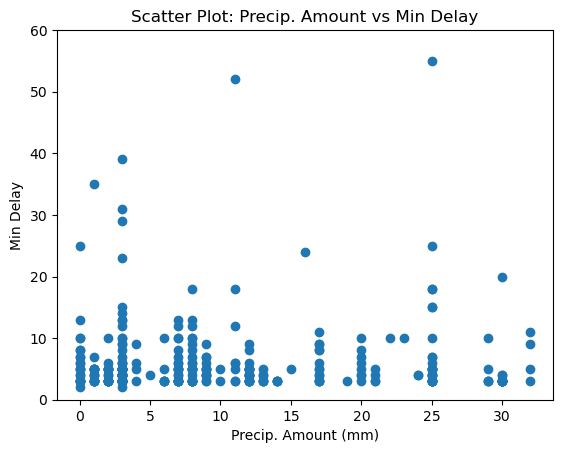

In [96]:
X = merged_df[['SNOW_ON_GROUND']]
y = merged_df['Min Delay']

plt.scatter(X, y)
plt.xlabel('Precip. Amount (mm)')
plt.ylabel('Min Delay')
plt.title('Scatter Plot: Precip. Amount vs Min Delay')
plt.ylim(0, 60)
plt.show()

Observation: Overall, the majority of the delay time is between 0 to 20 minutes desipite the precipitation amount.
There were fewer delay incidents at high precipitation (30mm). This may be due to the fact that there were fewer extreme snow events and thus the incidents were low.

Using IQR, for delay time exceeding 10 minute and less than 0 minute, the data will be considered as outlier and will be removed at the next section

## Process Data

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.base import clone


In [98]:
# Using pd.get_dummies to one-hot encode the text column
df_encoded = pd.get_dummies(merged_df, columns=['Weather'], prefix='WeatherType', drop_first=True)

In [99]:
df_encoded = df_encoded.dropna(subset=['Min Delay'])

In [100]:
df_encoded.columns

Index(['Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Line',
       'Vehicle', 'Code discription', 'Temp (°C)', 'Precip. Amount (mm)',
       'Wind Spd (km/h)', 'SNOW_ON_GROUND', 'WeatherType_Freezing Rain,Fog',
       'WeatherType_Haze', 'WeatherType_Heavy Snow',
       'WeatherType_Moderate Snow', 'WeatherType_Rain', 'WeatherType_Rain,Fog',
       'WeatherType_Snow', 'WeatherType_Snow,Blowing Snow',
       'WeatherType_Thunderstorms'],
      dtype='object')

In [101]:
# remove outlier
Q1,Q3 = df_encoded['Min Delay'].quantile(0.25),df_encoded['Min Delay'].quantile(0.75)
IQR = Q3 - Q1
df_encoded=df_encoded[(df_encoded['Min Delay']> (Q1-1.5*IQR)) &
                      (df_encoded['Min Delay']< (Q3+1.5*IQR))]
df_encoded.shape
df_encoded.head

<bound method NDFrame.head of                            Day             Station   Code  Min Delay  Min Gap  \
LOCAL_DATE                                                                      
2014-01-02 17:00:00   Thursday  DAVISVILLE STATION  PUSIS        3.0      6.0   
2014-01-02 21:00:00   Thursday  DAVISVILLE STATION  PUSIS        5.0      9.0   
2014-01-04 10:00:00   Saturday    EGLINTON STATION  PUSIS        5.0     10.0   
2014-01-06 07:00:00     Monday    EGLINTON STATION  PUSIS        5.0     10.0   
2014-01-06 14:00:00     Monday    YORKDALE STATION  PUSIS        3.0      7.0   
...                        ...                 ...    ...        ...      ...   
2023-02-21 09:00:00    Tuesday    ROSEDALE STATION  MUWEA        2.0      4.0   
2023-03-31 06:00:00     Friday    ROSEDALE STATION  MUWEA        8.0      NaN   
2023-04-05 10:00:00  Wednesday   OSSINGTON STATION  MUWEA        5.0      9.0   
2023-04-16 21:00:00     Sunday    ROSEDALE STATION  MUWEA        7.0     13.0  

In [102]:
# Find the index of 'Wind Spd (km/h)'
wind_speed_index = df_encoded.columns.get_loc('Wind Spd (km/h)')

# Split the data into features (X) and target variable (y)
# Select all columns to the right of 'Wind Spd (km/h)' and add additional columns
X = df_encoded.iloc[:, wind_speed_index:]
additional_columns = ['Temp (°C)', 'Precip. Amount (mm)', 'SNOW_ON_GROUND']
X = pd.concat([X, df_encoded[additional_columns]], axis=1)
y = df_encoded['Min Delay']

In [103]:
df_encoded.sort_values('Min Delay', ascending=False)

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code discription,Temp (°C),...,SNOW_ON_GROUND,"WeatherType_Freezing Rain,Fog",WeatherType_Haze,WeatherType_Heavy Snow,WeatherType_Moderate Snow,WeatherType_Rain,"WeatherType_Rain,Fog",WeatherType_Snow,"WeatherType_Snow,Blowing Snow",WeatherType_Thunderstorms
LOCAL_DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-12 22:00:00,Friday,DAVISVILLE STATION,PUSIS,10.0,13.0,N,YU,5726,Signals Track Weather Related,-9.7,...,6.0,False,False,False,False,False,False,False,False,False
2014-01-20 22:00:00,Monday,EGLINTON STATION,PUSIS,10.0,15.0,S,YU,5601,Signals Track Weather Related,-13.3,...,7.0,False,False,False,False,False,False,False,False,False
2019-01-29 16:00:00,Tuesday,DAVISVILLE BUILD UP,PUSIS,10.0,12.0,S,YU,5436,Signals Track Weather Related,-5.6,...,29.0,False,False,False,False,False,False,True,False,False
2014-02-09 09:00:00,Sunday,MCCOWAN STATION,MRWEA,10.0,17.0,N,SRT,3015,Weather Reports / Related Delays,-9.9,...,23.0,False,False,False,False,False,False,False,False,False
2020-01-12 08:00:00,Sunday,GREENWOOD STATION,MUWEA,10.0,NaN,E,BD,5366,Weather Reports / Related Delays,-4.5,...,2.0,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-19 17:00:00,Wednesday,MCCOWAN STATION,MRWEA,3.0,8.0,S,SRT,3022,Weather Reports / Related Delays,-3.1,...,3.0,False,False,False,False,False,False,True,False,False
2019-01-21 12:00:00,Monday,ST CLAIR STATION,PUSIS,3.0,5.0,S,YU,5456,Signals Track Weather Related,-14.5,...,8.0,False,False,False,False,False,False,False,False,False
2014-01-02 17:00:00,Thursday,DAVISVILLE STATION,PUSIS,3.0,6.0,N,YU,5601,Signals Track Weather Related,-16.6,...,8.0,False,False,False,False,False,False,False,False,False


In [104]:
X

,Wind Spd (km/h),SNOW_ON_GROUND,"WeatherType_Freezing Rain,Fog",WeatherType_Haze,WeatherType_Heavy Snow,WeatherType_Moderate Snow,WeatherType_Rain,"WeatherType_Rain,Fog",WeatherType_Snow,"WeatherType_Snow,Blowing Snow",WeatherType_Thunderstorms,Temp (°C),Precip. Amount (mm),SNOW_ON_GROUND
LOCAL_DATE,,,,,,,,,,,,,,
2014-01-02 17:00:00,26.0,8.0,False,False,False,False,False,False,False,False,False,-16.6,0.0,8.0
2014-01-02 21:00:00,26.0,8.0,False,False,False,False,False,False,False,False,False,-16.9,0.0,8.0
2014-01-04 10:00:00,50.0,9.0,False,False,False,False,False,False,False,False,False,-2.2,0.0,9.0
2014-01-06 07:00:00,35.0,12.0,False,False,False,False,False,False,False,False,False,-3.1,0.0,12.0
2014-01-06 14:00:00,41.0,12.0,False,False,False,False,False,False,False,False,False,-6.2,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 09:00:00,15.0,0.0,False,False,False,False,False,False,False,False,False,2.0,0.0,0.0
2023-03-31 06:00:00,21.0,0.0,False,False,False,False,False,False,False,False,False,2.3,0.0,0.0
2023-04-05 10:00:00,43.0,0.0,False,False,False,False,False,False,False,False,True,3.8,0.0,0.0


In [105]:
y

LOCAL_DATE
2014-01-02 17:00:00    3.0
2014-01-02 21:00:00    5.0
2014-01-04 10:00:00    5.0
2014-01-06 07:00:00    5.0
2014-01-06 14:00:00    3.0
                      ... 
2023-02-21 09:00:00    2.0
2023-03-31 06:00:00    8.0
2023-04-05 10:00:00    5.0
2023-04-16 21:00:00    7.0
2023-04-16 21:00:00    7.0
Name: Min Delay, Length: 288, dtype: float64

In [106]:
def cross_validate_with_test(model, X, y):
    
    # Split data into training and temporary data (which will be split into validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)

    # Further split the temporary data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_values = []

    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X_train):

        # Split data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Fit model on training data
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        pred_val = model.predict(X_val_fold)

        # Calculate RMSE on the validation set
        rmse_val = np.sqrt(mean_squared_error(y_val_fold, pred_val))

        # Append RMSE scores on validation set 
        rmse_values.append(rmse_val)

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Evaluate on the test set
    pred_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

    return rmse_values, rmse_test


In [107]:
cv_scores, test_score = cross_validate_with_test(model=LinearRegression(fit_intercept=True), X=X_train, y=y_train)

# Print cross-validation scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: {}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: {}'.format(np.std(cv_scores)))

# Print test set score
print('Test set RMSE score: {}'.format(test_score))

Cross-validation RMSE scores: [1.9599421697001507, 2.008108941055392, 1.8105776283023518, 2.001224010529529, 2.0160890309087423]
Cross-validation RMSE scores mean: 1.959188356099233
Cross-validation RMSE scores std: 0.0767901338986685
Test set RMSE score: 1.9289129563154643


In [108]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV


# Define the hyperparameters and their possible values
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}

# Use GridSearchCV to perform hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values
best_params = grid_search.best_params_

# Train the model with the best hyperparameter values on the full training set
best_model = LinearRegression(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Best Hyperparameters:', best_params)
print('Test Set RMSE:', rmse)


Best Hyperparameters: {'fit_intercept': True, 'positive': True}
Test Set RMSE: 1.957900859529897


In [67]:
# Split the data into 70% training and 30% temporary data (which will be split into validation and test)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)

# # Split the temporary data into 50% validation and 50% test
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# # Print results
# print('Train {}%'.format(X_train.shape[0] / X.shape[0] * 100))
# print('Val {}%'.format(X_val.shape[0] / X.shape[0] * 100))
# print('Test {}%'.format(X_test.shape[0] / X.shape[0] * 100))


In [49]:
# model = LinearRegression()
# model.fit(X_train, y_train)

LinearRegression()

In [50]:
# coefficients = model.coef_

# print("Coefficients:", coefficients)

Coefficients: [-7.48801706e-03 -8.46110549e-03 -9.30332200e-15 -3.96165712e-01
  1.49325535e+00  1.51222903e+00  7.61686648e-01  1.47418255e+00
  4.71575024e-01 -7.43223412e-01  7.69899431e-01 -3.04405362e-02
 -3.92007484e-01 -8.46110549e-03]


In [51]:
# intercept = model.intercept_
# print("Intercept:", intercept)


Intercept: 4.667759340831102


In [52]:
# y_train_pred = model.predict(X_train)
# mse = mean_squared_error(y_train, y_train_pred)
# r2 = r2_score(y_train, y_train_pred)
# print(f'Training Mean Squared Error: {mse}')
# print(f'Training R-squared: {r2}')



Training Mean Squared Error: 3.419517086347334
Training R-squared: 0.040171816210772704


In [53]:
# y_test_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_test_pred)
# r2 = r2_score(y_test, y_test_pred)
# print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}')

Mean Squared Error: 5.487482846664736
R-squared: 0.02462662585907749


In [54]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# mae = mean_absolute_error(y_test, y_test_pred)
# mse = mean_squared_error(y_test, y_test_pred)

# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 1.9320890808053988
Mean Squared Error: 5.487482846664736


In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=10000,
                    hidden_layer_sizes=(20, 10), random_state=1)
clf.fit(X_scaled, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(20, 10), max_iter=10000,
              random_state=1, solver='lbfgs')

In [56]:
X_test_scaled = scaler.transform(X_test)
y_train_pred = clf.predict(X_scaled)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


y_test_pred = clf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.572139303482587
R-squared: 0.839405560882071
Mean Squared Error: 7.5227272727272725
R-squared: -0.33712816746235785


Conclusion: After attempting both linear regression and neural network analyses, it is evident that the mean squared error is high, indicating that neither model is a suitable fit. This conclusion is based on the observation of a minimal correlation between snow precipitation and delay duration, as evidenced by the scatter plot. Even with the inclusion of additional factors such as precipitation and weather type, the model fails to capture the relationship effectively. Consequently, the regression model is excluded from the project.

From a project perspective, it is noteworthy that weather-related delays occur relatively infrequently compared to other causes, such as disorderly patrons. Given that the primary cause of delays—signal tracking—has already been identified, it is recommended that TTC shifts its focus to addressing more prevalent delay issues. This strategic shift is suggested to generate greater financial value by concentrating efforts on areas with higher frequency of occurrence.